In [1]:
ipython = get_ipython()
colab   = 'google.colab' in str(ipython)
print(ipython)

if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd '/content/gdrive/My Drive/Colab Notebooks'

!ls "./"

def MODULE_FROM_NOTEBOOK(target, source, *keys): 
    from json import load
    with open(source) as notebook:
        data = load(notebook)
        with open(target,'w') as module:
            for cell in data['cells']:
                lines = cell['source']
                if type(lines) == str:
                    lines = lines.split('\n')
                line0  = (lines or [''])[0].strip()
                haskey = lambda key: line0 == f'### {key} ###'
                if cell['cell_type'] == 'code' and any(map(haskey,keys)):
                    code = '\n'.join(lines)
                    module.write(code)
                    module.write('\n')
                     
MODULE_FROM_NOTEBOOK('./ttt_tactics.py',
                     './ttt-tactics.ipynb',
                     'HEAD','GAME','DATA','MODEL','SEARCH')

from ttt_tactics import *

!cat /proc/meminfo | grep Mem

ipynb = 'ttt-tactics-train'

%load_ext tensorboard

!rm -rf "./tensorboard/"


'!!!.ipynb'    ttt-tactics	        ttt_tactics.py
 __pycache__   ttt-tactics.ipynb        ttt-tactics-test.ipynb
 ttt-3.ipynb   ttt-tactics-play.ipynb   ttt-tactics-train.ipynb
INFO:tensorflow:Using local port 23016
INFO:tensorflow:Using local port 19966
INFO:tensorflow:Using local port 21182
INFO:tensorflow:Using local port 22199
INFO:tensorflow:Using local port 15042
INFO:tensorflow:Using local port 19894
INFO:tensorflow:Using local port 20745
INFO:tensorflow:Using local port 15207
INFO:tensorflow:Using local port 15365
INFO:tensorflow:Using local port 22914
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
cuda: False
tensorflow: 2.4.0
DIR = ./ttt-tactics
MODULE =  ttt_tactics
<function savesamples at 0x7ffb8dbe9430>
<function loadsamples at 0x7ffb8dbe9670>
<class 'ttt_tactics.AlphaZeroModel'>
<function AlphaZeroPolicy at 0x7ffb8dbe98b0>
MemTotal:       16393932 kB
MemFree:         9548876 kB
MemAvailable:   13486512 kB


./ttt-tactics/model-008.h5 Nov 12 2020 10:46:40
num = 8
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Do not call `graph_parents`.
path = ./ttt-tactics/data-*.tfrec
files: 51
2471/2471 [==============================] - 1722s 692ms/step - loss: 2.3203 - value_loss: 0.7491 - policy_loss: 1.5712 - value_lr: 1.0000e-04


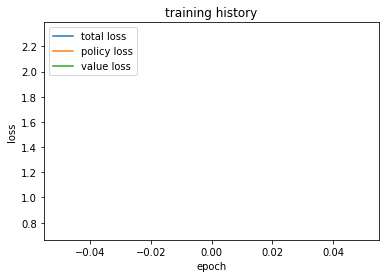

path = ./ttt-tactics/data-*.tfrec
files: 51
    141/Unknown - 157s 963ms/step - loss: 2.3495 - value_loss: 0.7752 - policy_loss: 1.5742 - value_lr: 1.0000e-04

In [ ]:
%%monitor_cell "ttt-tactics train"

model   = AlphaZeroModel()
minloss = 2.31

models = sortedfiles(f'{DIR}/model-*.h5')
model.load(models[-1])
num = int(re.findall(r'\d+', str(model))[0]) 
print('num =', num)

iters = 10000
while iters > 0:
    iters  -= 1
    path    = f'{DIR}/data-*.tfrec'
    files   = sortedfiles(path)
    dataset = loadsamples(files, buffer_size=200*1024, batch_size=1024, seed=None)
    print('path =',path)
    print('files:',len(files))

    schedule = { 0:0.0001 }
    def onschedule(epoch, lr): 
        if epoch in schedule: return schedule[epoch]  
        else:                 return lr
    scheduler = LearningRateScheduler(onschedule)

    # tensorboard = TensorBoard(log_dir        = f'./tensorboard/logs-{time()}', 
    #                           histogram_freq = 1,
    #                           write_graph    = True,
    #                           write_images   = False,
    #                           update_freq    = 'epoch', 
    #                           profile_batch  = 0)

    history = model.fit(
        x                   = dataset,
        epochs              = 1,
        verbose             = 1,
        callbacks           = [scheduler],
        workers             = 10,
        use_multiprocessing = False)
    history = history.history

    loss = history['loss'][-1]
    ok   = loss < minloss
    if ok:
        minloss = loss
        model.save(f'{DIR}/model-{(num+1):0>3d}.h5')

    plt.figure()
    plt.plot(history['loss'],        label='total loss')
    plt.plot(history['policy_loss'], label='policy loss')
    plt.plot(history['value_loss'],  label='value loss')
    plt.title('training history')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc="upper left")
    plt.savefig(f'{DIR}/{str(model)}.png')
    plt.show()

    ok = 'OK' if ok else 'NO'
    NOTIFY(f'{str(model)} {ok}, loss: {loss}, left={iters}, shell={str(ipython)}', title=ipynb)


In [ ]:
model.save(f'{DIR}/model-{num:0>3d}.h5')